Student's t-test is considered harmful for AB testing. Also, outlier filtering doesn't help. A thread investigating a simple solution. How do you measure the effect of an AB test?

_This notebook is associated with [this Twitter thread]()_

You've finished your AB test and you have the data. You have the revenue for each user that saw version A of your app, and also for each user that saw version B. Which version generated the most revenue? Is there a _significant_ difference? What is the _confidence interval_?

It's tempting to try a Student's t-test, but it's valid only for data with small finite variance.

In e-commerce, the data is often _heavy-tailed_, sometimes one user out of thousands of users will be responsible for 10% of the total revenue. Here are the _survival functions_ of hundreds of datasets I see in my day job. The datasets at the bottom have a straight line in this log-log scale, which is consistent with a Pareto distribution. Depending on the parameters, such a distribution can have infinite variance or even an infinite mean.

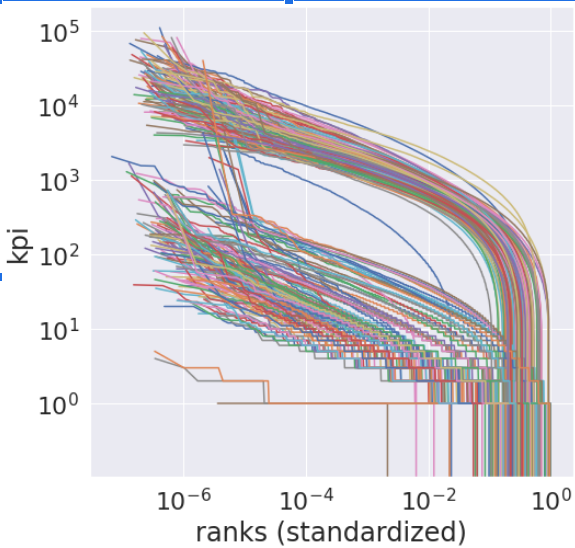

You might have heard that 30 observations is enough to ensure normality, but that has always been fake news. With infinite variance, the difference in sample means will also have infinite variance and therefore the Student's t-test is unworkable even with billions of observations.

## Outlier filtering

A naive solution is 'outlier filtering'. Before the t-test, remove the largest 0.1% of values and then do a t-test on the remaining data. There are a number of fatal flaws with this, but I'll focus initially on the bias. If version B causes users to spend more, then outlier filtering can remove many users from the B group, and remove fewer users from the A group. This shrinks the estimates towards zero.

Here is one simulation where you can see the outlier filtering estimates are always around zero, whereas another method (discussed later in this thread) has estimates around the true effect size.

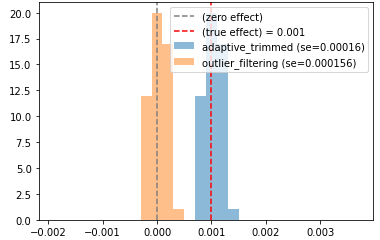

... that's a slightly contrived example which makes the case very obvious. But it's a useful starting point. For all the code behind these plots, go to the Jupyter notebook: ...

This means that version B might be truly quite harmful, but we have a high chance that the test will not notice the harm. It will likely give a small confidence interval around zero, leading to a false conclusion that the true effect is negligible. This is why outlier filtering with a Student's t-test should not be used.

# So, what is a valid way to estimate the effect?

So what do we do instead? "adaptive trimmed means" is the method I investigate here.

I learned a lot from @Susan_Athey 's recent paper on this topic. I didn't implement the methods that she introduced, but I learned about "adaptive trimmed means" from it:

https://twitter.com/patrickdoupe/status/1435253137909108743

But before defining and evaluating the 'adaptive trimmed means' method, let's recap what we need. The true difference in means (if finite) is $\theta$. Our estimator will provide two numbers: $\hat\theta$ and $\hat\sigma^2$. We want a normally-distributed unbiased estimator with the correct variance. More formally, we want $\hat\theta$ and $\hat\sigma^2$ to be distributed as follows:


$$ \frac{\hat\theta - \theta}{\sqrt{\hat\sigma^2}} \sim N(0,1) $$



This property is needed to compute valid p-values and confidence intervals. A small amount of bias can be acceptable, but only if the bias is small relative to the standard error.

## Trimmed mean

Given $0 < \alpha < \frac12$, the _trimmed mean_ of a distribution is the mean of the distribution after discarding the largest and smallest values. Where $F$ is the _cumulative distribution function_, the trimmed mean is:

$$ E\left[X | F^{-1}(\alpha) < X < F^{-1}(1-\alpha) \right] $$

The trimmed mean always exists (is finite), even for distributions with infinite mean. The _sample trimmed mean_ is the mean in a sample after discarding the largest $\alpha n$ values and the smallest $\alpha n$ values. The question then is: is the _sample trimmed mean_ a good estimate of the true _trimmed mean_?

The variance of this estimator is as follows, from the Athey paper. Note the word 'asymptotic', it will break down at small sample sizes:

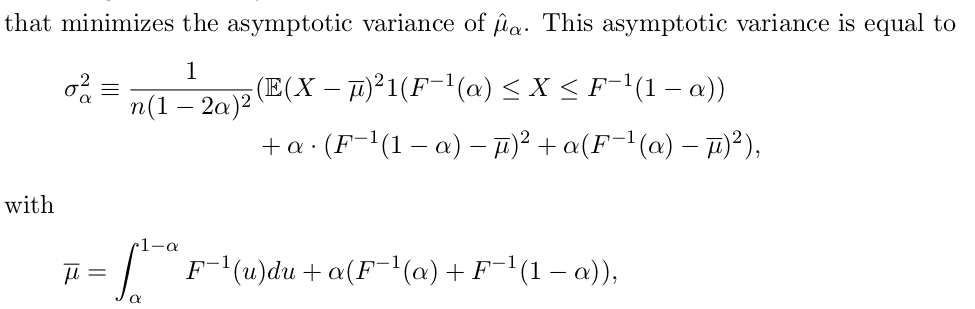

In [1]:
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats

In [2]:
# Given a sample and the alpha, compute the trimmed mean and the variance of this estimator
def compute_trimmed_mean_of_a_single_group(xs, alpha):
    assert 0 < alpha < 0.5
    n = len(xs)
    delete_above_this = np.quantile(xs, 1-alpha)
    delete_below_this = np.quantile(xs,   alpha)
    
    filtered = xs[(xs <= delete_above_this) & (xs >= delete_below_this)]
    trimmed_mean = np.mean(filtered)
    
    # Calculate the (asymptotic) variance using section 2.4 of
    # Susan Athey's paper: https://arxiv.org/abs/2109.02603
       
    # mu_bar is the mean where the large and small values are truncated (*not* removed)
    truncated = np.maximum(np.minimum(xs, delete_above_this), delete_below_this)
    mu_bar = np.mean(truncated)
        
    squared_difference = (xs - mu_bar)**2
    squared_difference[(xs > delete_above_this) | (xs < delete_below_this)] = 0
    first_term = np.mean(squared_difference)
    second_term = alpha * (delete_above_this - mu_bar)**2
    third_term = alpha * (delete_below_this - mu_bar)**2
    asymptotic_variance = 1 / (n * (1-2*alpha)**2) * (first_term+second_term+third_term)
    return trimmed_mean, asymptotic_variance

In [3]:
def thorough_check_of_variance_of_2sidedtrimmed_mean(dist, n, alpha, repeats):
    # We can compute the true trimmed mean of the distribution by using a very
    # large number of quantiles.
    really_large_constant = 10000000
    true_sample = dist.ppf(np.arange(.5/really_large_constant + alpha, 1-alpha, 1/really_large_constant))
    true_2sided_trimmed_mean = np.mean(true_sample)
    
    def one_simulation():
        xs = dist.rvs(n)
        est, var = compute_trimmed_mean_of_a_single_group(xs, alpha)
        return (est - true_2sided_trimmed_mean) / np.sqrt(var)
    
    return np.array([one_simulation() for _ in range(repeats)])
   

In [4]:
def plot_to_check_it_is_standard_normal(zs):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.hist(zs)
    plt.subplot(1,2,2)
    plt.scatter(scipy.stats.norm().ppf(np.arange(.5, len(zs))/len(zs)), sorted(zs))
    plt.axline((0,0), slope=1, color='red')
    print(f"Type I error rate is about: {np.mean(abs(zs) > abs(scipy.stats.norm.ppf(0.025)))}")

We demonstrate that the _sample trimmed mean_ is a good estimator of the true _trimmed mean_ by computing the ratio in the formula above and demonstrating that it is a standard normal (approximately). A first simple example involves samples of 1000 observations from a log-normal distribution, and trimming with $\alpha=0.01$. We repeat this 10,000 times and this gives us 10,000 values which should be a standard normal. We plot a histogram and a qq-plot to confirm the normality.

Type I error rate is about: 0.047
CPU times: user 4.69 s, sys: 131 ms, total: 4.82 s
Wall time: 4.82 s


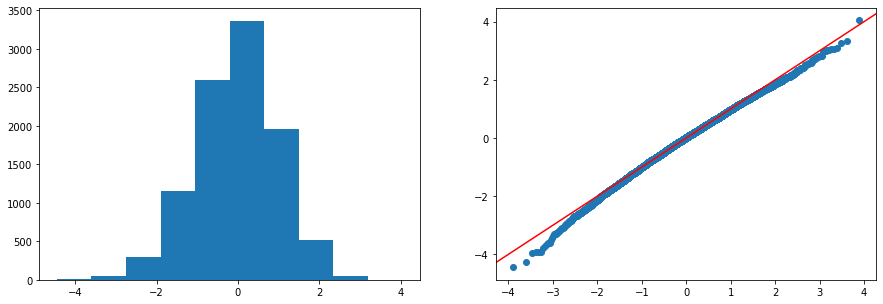

In [5]:
%%time
zs = thorough_check_of_variance_of_2sidedtrimmed_mean(
    scipy.stats.lognorm(loc=0, s=1)
    , n=1000, alpha=0.01, repeats=10000)
plot_to_check_it_is_standard_normal(zs)

Of course, this is just one arbitrary simple example. The performance will depend on the choice of distribution, the choice of sample size, and the choice of $\alpha$. We'll return to this below.

## Adaptive trimmed means

After the AB test, we apply this trimmed mean estimator to the two groups, group A and group B, separately.
The difference in the two estimates is taken as the estimate of the treatment effect, and the variance of the estimator is the sum of the two variances. We can evaluate this using a similar approach, compute the ratio of the actual error to the standard error and checking that the ratio has a standard normal distribution.

But, what $\alpha$ should we use? This is the most exciting idea that I learned from the Athey paper. We simply use the $\alpha$ that minimizes the variance. We define a collection of candidate $\alpha$s, apply this estimator for each $\alpha$, and choose the one with smallest variance.

## Simulations

The simulation framework is as follows: A distribution is specified (any distribution available in Python's `scipy`), and a sample size `n`. `n` observations are then drawn from the distribution. A 'treatment function' is then applied to half of the data (group B). The other half of the data (group A) is left unchanged. In principle, any treatment function can be used, but we focus on additive treatments here; this means that the true group A distribution and the true group B distribution are identical up to a 'translation'.

In [6]:
# First, define a function that simulates the data for one 'experiment', taking as inputs the distribution, the sample size, and the treatment function
def two_samples(dist, n, treatment_function):
    assert n % 2 == 0 # 'n' must be even, so that we can evenly split it in two
    # This function returns two vectors.
    # The first vector is the control group, created by drawing 'n' observations from the 'dist'.
    # The second vector is the treatment groups. It is also created by drawing 'n' observations
    # from 'dist', but we the apply the function 'treatment_function' before returning it.
    # For example, 'treatment_function' might be 'lambda x: x+2' to simulate a treatment which
    # causes each user to spend two extra euros.
    a = dist.rvs(n // 2)
    b = dist.rvs(n // 2)
    return a, treatment_function(b)

two_samples(scipy.stats.pareto(1), 10, lambda x: x+3)

(array([1.54476904e+00, 6.72706164e+00, 1.24444359e+00, 1.52223660e+00,
        1.40553249e+03]),
 array([5.07826506, 4.09472853, 4.20450322, 5.4091372 , 5.24854543]))

In [7]:
# We define estimators below. Here, we define a class to store an estimate.

class Estimate(namedtuple('Estimate', 'point_estimate variance', module = __name__)):
    # 'point_estimate' is a floating point number.
    # 'variance' may be 'None', or a floating point number. Some methods know how
    # to estimate their own variance, but some methods don't.
    pass

In [8]:
# Define the simplest possible estimator. Taking the raw data and returning the difference in the two sample means.

def estimator_raw_sample_means(a, b):
    return Estimate(point_estimate = np.mean(b) - np.mean(a), variance = None)

In [9]:
# Next, define the outlier filtering estimator.
# We'll always use 0.999 in these examples, discarding the largest 0.1% from the combined sample

def estimator_outlier_filtering(threshold):
    # 'threshold' is a number between 0 and 1, e.g 0.999, to apply outlier filtering.
    def go(a, b):
        # combine the two vectors together, and then compute the quantile
        all_together = np.concatenate((a,b))
        n = len(all_together)
        delete_above_this = np.quantile(all_together, threshold)
        
        # Remove values that are too large
        a = a[a <= delete_above_this]
        b = b[b <= delete_above_this]
        
        #print(len(a), len(b))
        num_removed = n - len(a) - len(b)
        
        # The variance calculation used in the Student's t-test (the 'pooled variance') is invalid in
        # the context of outlier filtering. Therefore, we won't return a variance here:
        return Estimate(point_estimate = np.mean(b) - np.mean(a), variance = None)
    return go

In [10]:
def estimator_adaptive_2sidedtrimmed_means(alphas):
    def go(a, b):
        # Compute a list of two-tuples, pairing the variance with the corresponding alpha
        variances_for_each_possible_alpha = [(
            compute_trimmed_mean_of_a_single_group(a,alpha)[1] + compute_trimmed_mean_of_a_single_group(b,alpha)[1]
            , alpha
        ) for alpha in alphas]
        variance_at_the_optimal_alpha, optimal_alpha = min(variances_for_each_possible_alpha)

        #print(f"optimal_alpha = {optimal_alpha:.3g}")

        estimate_c, estimate_c_var = compute_trimmed_mean_of_a_single_group(a, optimal_alpha)
        estimate_t, estimate_t_var = compute_trimmed_mean_of_a_single_group(b, optimal_alpha)

        return Estimate(point_estimate = estimate_t - estimate_c, variance = estimate_c_var + estimate_t_var)
    return go
        
estimator_adaptive_2sidedtrimmed_means(alphas = np.arange(0.01, 0.49, 0.05))(*two_samples(scipy.stats.lognorm(s=.5), 10000, lambda x: x))

Estimate(point_estimate=-0.023224887080848466, variance=0.0001242873583187495)

In [11]:
def thorough_check_of_the_adaptive_2sided_trimmed_means_estimator(repeats, dist, n, treatment_function, alphas):
    # We can compute the true ATE (modulo a tiny bit of noise) deterministically as follows
    really_large_constant = 10000000
    qs = np.arange(.5, really_large_constant) / really_large_constant
    true_ATE = np.mean(treatment_function(dist.ppf(qs)) - dist.ppf(qs))
    
    def go():
        a = dist.rvs(n // 2)
        b = treatment_function(dist.rvs(n // 2))
        est, var = estimator_adaptive_2sidedtrimmed_means(alphas)(a, b)
        return (est - true_ATE) / np.sqrt(var)
    
    zs = np.array([go() for _ in range(repeats)])
    
    plot_to_check_it_is_standard_normal(zs)

Type I error rate is about: 0.048
CPU times: user 12.2 s, sys: 240 ms, total: 12.4 s
Wall time: 12.4 s


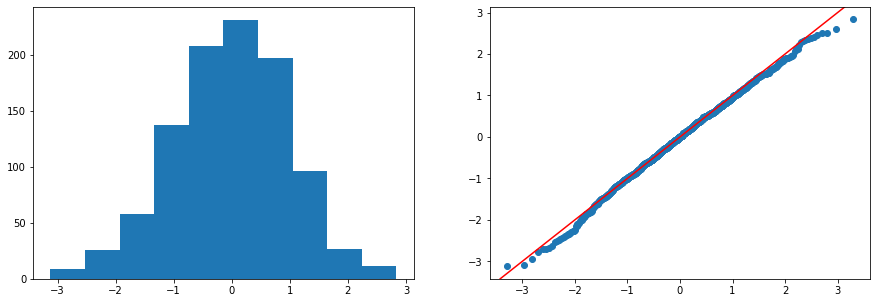

In [12]:
%%time
thorough_check_of_the_adaptive_2sided_trimmed_means_estimator(repeats = 1000,
                                                              dist = scipy.stats.lognorm(s=0.5),
                                                              n = 10000,
                                                              treatment_function = lambda x: x+4,
                                                              alphas = np.arange(0.01, 0.49, 0.05),
                                                             )

Type I error rate is about: 0.013
CPU times: user 12.6 s, sys: 320 ms, total: 12.9 s
Wall time: 12.9 s


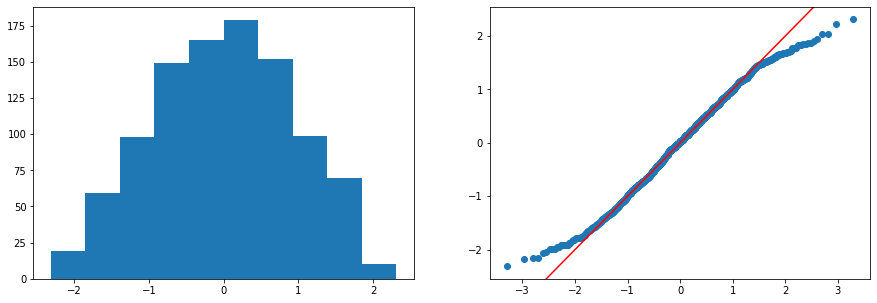

In [13]:
%%time
thorough_check_of_the_adaptive_2sided_trimmed_means_estimator(repeats = 1000,
                                                              dist = scipy.stats.pareto(.05),
                                                              n = 10000,
                                                              treatment_function = lambda x: x+4,
                                                              alphas = np.arange(0.01, 0.49, 0.05),
                                                             )

In [14]:
[
    # Compute the ratio of the largest value to the total value ...
    max(xs) / sum(xs)
    # ... in the following random sample:
    for xs in [scipy.stats.pareto(.05).rvs(10000)
               # Repeat this a few times:
               for _ in range(10)
              ]
]

[1.0,
 0.9987107512892714,
 0.9999999998891568,
 0.9892515409222742,
 0.9838658125631374,
 0.842881176943669,
 0.9936924288145286,
 1.0,
 1.0,
 0.9999923879981485]

/home/amcdaid/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in square


Type I error rate is about: 0.041
CPU times: user 32 s, sys: 304 ms, total: 32.3 s
Wall time: 32.3 s


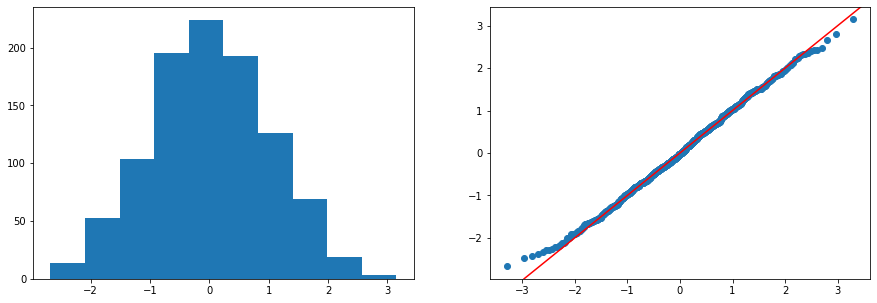

In [17]:
%%time
thorough_check_of_the_adaptive_2sided_trimmed_means_estimator(repeats = 1000,
                                                              dist = scipy.stats.pareto(.05),
                                                              n = 50000,
                                                              treatment_function = lambda x: x+4,
                                                              alphas = np.arange(0.01, 0.49, 0.05),
                                                             )

In [18]:
def apply_multiple_estimators(a, b, **named_estimators):
    dfs = []
    for estimator_name, estimator_func in named_estimators.items():
        point_estimate, variance = estimator_func(a, b)
        dfs.append(
            pd.DataFrame(dict(
                estimator_name = estimator_name,
                point_estimate = point_estimate,
                variance = variance,
            ), index=[None])
        )
    return pd.concat(dfs).reset_index(drop=True)
    

In [29]:
def plot_many_simulations(repeats, dist, n, treatment_function, **estimators):
    #true_control_mean = dist.mean()
    #true_treatment_mean = treatment_function(dist.mean())
    ## TODO: this next line is correct only for translations. This can be easily fixed
    #true_effect = true_treatment_mean - true_control_mean
    
    # We can compute the true ATE (modulo a tiny bit of noise) deterministically as follows
    really_large_constant = 10000000
    qs = np.arange(.5, really_large_constant) / really_large_constant
    true_effect = np.mean(treatment_function(dist.ppf(qs)) - dist.ppf(qs))
    
    many = pd.concat(
        [
    apply_multiple_estimators(*two_samples(
        dist, n, treatment_function)
                              , **estimators
                             )
            for _ in range(repeats)
            for __ in [print(_, end=' ')]
        ])
    
    print()
    print(true_effect)

    plt.axvline(0, color='grey', ls='--', label=f'(zero effect)')
    plt.axvline(true_effect, color='red', ls='--', label=f'(true effect) = {true_effect:.2g}')
    histogram_bins = np.arange(-1.9*true_effect,3.9*true_effect,0.2*true_effect)
    for estimator_name, _ in many.groupby('estimator_name'):
        se = np.std(_.point_estimate)
        plt.hist(_.point_estimate,
                 label=f"{estimator_name} (se={se:.3g})",
                 alpha=0.5,
                 bins = histogram_bins,
                )
    plt.legend()
    
    #display(many.groupby('estimator_name').median())
    #display(many.groupby('estimator_name').mean())
    #display(many.groupby('estimator_name').std())

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
0.001000000000000001
CPU times: user 52.2 s, sys: 8.48 s, total: 1min
Wall time: 1min


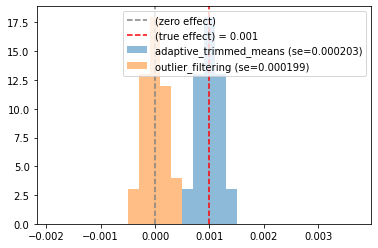

In [30]:
%%time
plot_many_simulations(
    repeats = 50,
    dist = scipy.stats.uniform(0,1),
    n = 10000000,
    treatment_function = lambda x: x * 1.002,
    
    outlier_filtering = estimator_outlier_filtering(0.999),
    adaptive_trimmed_means = estimator_adaptive_2sidedtrimmed_means(alphas=np.arange(.01,.49, .02))
    )

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 
0.04999999999999891


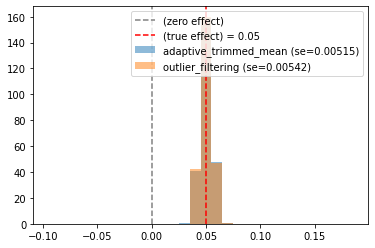

In [31]:
plot_many_simulations(
    repeats = 250,
    dist = scipy.stats.lognorm(s=0.5),
    n = 50000,
    treatment_function = lambda x: x + 0.05,
    
    outlier_filtering = estimator_outlier_filtering(0.999),
    adaptive_trimmed_mean = estimator_adaptive_2sidedtrimmed_means(alphas=np.arange(.01,.49, .02))
    )

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 
0.04999999999999901


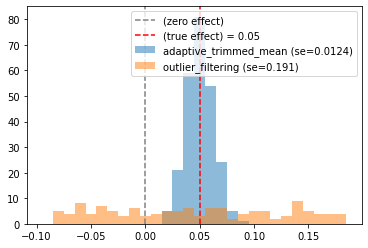

In [32]:
plot_many_simulations(
    repeats = 250,
    dist = scipy.stats.pareto(1.0),
    n = 100000,
    treatment_function = lambda x: x + 0.05,
    
    outlier_filtering = estimator_outlier_filtering(0.999),
    adaptive_trimmed_mean = estimator_adaptive_2sidedtrimmed_means(alphas=np.arange(.01,.49, .02))
    )

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 
0.07999234857012799


,point_estimate
estimator_name,
adaptive_trimmed_mean,0.057297
outlier_filtering,0.074405


,point_estimate
estimator_name,
adaptive_trimmed_mean,0.057322
outlier_filtering,0.074199


,point_estimate
estimator_name,
adaptive_trimmed_mean,0.004264
outlier_filtering,0.011576


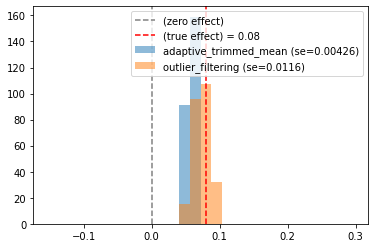

In [26]:
plot_many_simulations(
    repeats = 250,
    dist = scipy.stats.pareto(2),
    n = 100000,
    treatment_function = lambda x: x * 1.04,
    
    outlier_filtering = estimator_outlier_filtering(0.999),
    adaptive_trimmed_mean = estimator_adaptive_2sidedtrimmed_means(alphas=np.arange(.01,.49, .02))
    )